#### Import Packages

In [18]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from scipy.stats import chisquare


In [12]:
df = pd.read_csv(r"cookie_cats.csv")
'''
    userid :A unique number that identifies each player.
    version: Which A/B group the player was assigned to:
        gate_30 = control (the “gate” is at level 30)
        gate_40 = treatment (the gate was moved to level 40)
    sum_gamerounds: Engagement measure — how many rounds the player played in the first 14 days after installing.
    retention_1: Did the player come back and play 1 day after installing?
    retention_7: Did the player come back and play 7 days after installing?

    A/B test question: Does moving the gate from level 30 to level 40 change retention (day 1 and day 7), and by how much?
'''

'\n    userid :A unique number that identifies each player.\n    version: Which A/B group the player was assigned to:\n        gate_30 = control (the “gate” is at level 30)\n        gate_40 = treatment (the gate was moved to level 40)\n    sum_gamerounds: Engagement measure — how many rounds the player played in the first 14 days after installing.\n    retention_1: Did the player come back and play 1 day after installing?\n    retention_7: Did the player come back and play 7 days after installing?\n\n    A/B test question: Does moving the gate from level 30 to level 40 change retention (day 1 and day 7), and by how much?\n'

In [13]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [16]:
print(df.shape)
print(df.dtypes)
print(df.isna().sum())

(90189, 5)
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [17]:
# 3) Confirm groups + basic counts (needed for SRM check next)
print(df["version"].value_counts(dropna=False))

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


In [22]:
counts = df["version"].value_counts()

observed = np.array([counts["gate_30"], counts["gate_40"]])
expected = np.array([0.5 * observed.sum(), 0.5 * observed.sum()])  #build the expected group counts under the assumption that assignment was 50/50

chi2, p = chisquare(f_obs=observed, f_exp=expected)

print("Observed:", observed)
print("Expected:", expected.astype(int))
print("Chi-square:", chi2)
print("SRM p-value:", p)


Observed: [44700 45489]
Expected: [45094 45094]
Chi-square: 6.9024049496058275
SRM p-value: 0.008607987810836262


H₀: The traffic allocation matches the intended split — i.e., the probability a user is assigned to each variant equals the expected proportions (here 50% gate_30 and 50% gate_40), so any observed count differences are just random sampling noise.

p = 0.0086 (< 0.01) ⇒ the split (44,700 vs 45,489) is statistically inconsistent with a perfect 50/50 assignment.
Practically, it’s a small imbalance (~0.87 percentage-point difference), 
but SRM is a diagnostic alarm: it can indicate an assignment/logging issue.

#### Compute 1-day & 7-day retention rates, effect size, and run the two-proportion tests + 95% CI.

In [24]:
# Retention rates by group
summary = df.groupby("version")[["retention_1", "retention_7"]].mean()
counts = df["version"].value_counts()

print("Group sizes:\n", counts, "\n")
print("Retention rates:\n", summary, "\n")


Group sizes:
 version
gate_40    45489
gate_30    44700
Name: count, dtype: int64 

Retention rates:
          retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000 



In [25]:
# Convert to counts of retained users
ret1_success = df.groupby("version")["retention_1"].sum()
ret7_success = df.groupby("version")["retention_7"].sum()

print("Day-1 retained counts:\n", ret1_success, "\n")
print("Day-7 retained counts:\n", ret7_success)


Day-1 retained counts:
 version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64 

Day-7 retained counts:
 version
gate_30    8502
gate_40    8279
Name: retention_7, dtype: int64


These results summarize retention for each A/B group: 
- gate_30 (control) has 44,700 users and gate_40 (treatment) has 45,489 users. 
- The Day-1 retention rate is 44.82% for gate_30 (20,034 users returned the next day) versus 44.23% for gate_40 (20,119 returned),
- The Day-7 retention rate is 19.02% for gate_30 (8,502 returned) versus 18.20% for gate_40 (8,279 returned).
- In both cases, retention is slightly lower when the gate is moved to level 40, but we still need statistical testing and confidence intervals to judge whether these gaps are real and practically meaningful.

In [26]:
# Group order: control = gate_30, treatment = gate_40
n_ctrl = (df["version"] == "gate_30").sum()
n_trt  = (df["version"] == "gate_40").sum()

x1_ctrl = df.loc[df["version"] == "gate_30", "retention_1"].sum()
x1_trt  = df.loc[df["version"] == "gate_40", "retention_1"].sum()

x7_ctrl = df.loc[df["version"] == "gate_30", "retention_7"].sum()
x7_trt  = df.loc[df["version"] == "gate_40", "retention_7"].sum()

def diff_ci(p_trt, n_trt, p_ctrl, n_ctrl, alpha=0.05):
    # Normal approx CI for difference in proportions: (p_trt - p_ctrl)
    z = stats.norm.ppf(1 - alpha/2)
    se = np.sqrt(p_trt*(1-p_trt)/n_trt + p_ctrl*(1-p_ctrl)/n_ctrl)
    diff = p_trt - p_ctrl
    return diff, diff - z*se, diff + z*se, se

def run_prop_test(x_ctrl, n_ctrl, x_trt, n_trt, label):
    p_ctrl = x_ctrl / n_ctrl
    p_trt  = x_trt  / n_trt

    # Two-sided z-test for proportions
    zstat, pval = proportions_ztest(count=[x_trt, x_ctrl], nobs=[n_trt, n_ctrl], alternative="two-sided")

    diff, lo, hi, se = diff_ci(p_trt, n_trt, p_ctrl, n_ctrl)

    print(f"\n=== {label} ===")
    print(f"Control (gate_30): {p_ctrl:.6f}  ({x_ctrl}/{n_ctrl})")
    print(f"Treat   (gate_40): {p_trt:.6f}  ({x_trt}/{n_trt})")
    print(f"Absolute lift (trt-ctrl): {diff:.6%}")
    print(f"95% CI for lift: [{lo:.6%}, {hi:.6%}]")
    print(f"z = {zstat:.4f}, p-value = {pval:.6g}")

run_prop_test(x1_ctrl, n_ctrl, x1_trt, n_trt, "Day-1 retention")
run_prop_test(x7_ctrl, n_ctrl, x7_trt, n_trt, "Day-7 retention")



=== Day-1 retention ===
Control (gate_30): 0.448188  (20034/44700)
Treat   (gate_40): 0.442283  (20119/45489)
Absolute lift (trt-ctrl): -0.590517%
95% CI for lift: [-1.239244%, 0.058210%]
z = -1.7841, p-value = 0.0744097

=== Day-7 retention ===
Control (gate_30): 0.190201  (8502/44700)
Treat   (gate_40): 0.182000  (8279/45489)
Absolute lift (trt-ctrl): -0.820130%
95% CI for lift: [-1.328155%, -0.312104%]
z = -3.1644, p-value = 0.00155425


- For Day-1 retention, gate_40 is 0.59 percentage points lower than gate_30 (44.23% vs 44.82%), but the result is not statistically significant at 5% (p = 0.074), and the 95% CI (−1.24% to +0.06%) includes zero—so we can’t rule out “no real change” for Day-1. 
- For Day-7 retention, gate_40 is 0.82 percentage points lower than gate_30 (18.20% vs 19.02%), and this drop is statistically significant (p = 0.00155) with a 95% CI from −1.33% to −0.31%, meaning the data strongly suggests moving the gate to level 40 reduces week-1 retention by a small but likely real amount.

#### Practical impact: how many fewer retained users per 100,000 installs?


In [27]:
p1_ctrl, p1_trt = x1_ctrl/n_ctrl, x1_trt/n_trt
p7_ctrl, p7_trt = x7_ctrl/n_ctrl, x7_trt/n_trt

lift1 = p1_trt - p1_ctrl
lift7 = p7_trt - p7_ctrl

per100k_day1 = lift1 * 100_000
per100k_day7 = lift7 * 100_000

print("Day-1 lift:", lift1, "=> per 100k installs:", per100k_day1)
print("Day-7 lift:", lift7, "=> per 100k installs:", per100k_day7)

# adjust p-values for testing both retention_1 and retention_7 (Holm)
pvals = np.array([0.0744097, 0.00155425])
rej, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method="holm")

print("\nHolm adjusted p-values:")
print("Day-1:", pvals_adj[0], "reject?", rej[0])
print("Day-7:", pvals_adj[1], "reject?", rej[1])


Day-1 lift: -0.005905169787341458 => per 100k installs: -590.5169787341458
Day-7 lift: -0.008201298315205913 => per 100k installs: -820.1298315205913

Holm adjusted p-values:
Day-1: 0.0744097 reject? False
Day-7: 0.0031085 reject? True


In practical terms, moving the gate to level 40 corresponds to about 590 fewer Day-1 retained players per 100,000 installs and about 820 fewer Day-7 retained players per 100,000 installs, based on the observed absolute lifts (−0.59% for Day-1 and −0.82% for Day-7). When we account for testing two retention metrics using a Holm multiple-testing correction, the Day-1 result remains not statistically significant (adjusted p ≈ 0.074 → we can’t confidently say Day-1 retention changed), while the Day-7 drop remains statistically significant (adjusted p ≈ 0.0031), reinforcing the conclusion that the gate move to level 40 likely reduces week-1 retention by a small but meaningful amount.

#### Bootstrap CI for lift

In [29]:
rng = np.random.default_rng(42)

def bootstrap_lift_binary(df, metric, group_col="version", ctrl="gate_30", trt="gate_40",
                          n_boot=20000, ci=0.95, seed=42):
    rng = np.random.default_rng(seed)

    x_ctrl = df.loc[df[group_col] == ctrl, metric].to_numpy(dtype=np.int8)
    x_trt  = df.loc[df[group_col] == trt,  metric].to_numpy(dtype=np.int8)

    n_ctrl = x_ctrl.size
    n_trt  = x_trt.size

    # observed lift
    lift_obs = x_trt.mean() - x_ctrl.mean()

    # bootstrap lifts (resample within each group)
    lifts = np.empty(n_boot, dtype=np.float64)
    for b in range(n_boot):
        ctrl_bs = x_ctrl[rng.integers(0, n_ctrl, size=n_ctrl)]
        trt_bs  = x_trt[rng.integers(0, n_trt,  size=n_trt)]
        lifts[b] = trt_bs.mean() - ctrl_bs.mean()

    alpha = 1 - ci
    lo = np.quantile(lifts, alpha/2)
    hi = np.quantile(lifts, 1 - alpha/2)

    return lift_obs, lo, hi, lifts

# Day-1
lift1, lo1, hi1, lifts1 = bootstrap_lift_binary(df, "retention_1", n_boot=20000, seed=42)
print("Bootstrap Day-1 lift (trt-ctrl):", f"{lift1:.6%}")
print("Bootstrap 95% CI:", f"[{lo1:.6%}, {hi1:.6%}]")

# Day-7
lift7, lo7, hi7, lifts7 = bootstrap_lift_binary(df, "retention_7", n_boot=20000, seed=42)
print("\nBootstrap Day-7 lift (trt-ctrl):", f"{lift7:.6%}")
print("Bootstrap 95% CI:", f"[{lo7:.6%}, {hi7:.6%}]")


Bootstrap Day-1 lift (trt-ctrl): -0.590517%
Bootstrap 95% CI: [-1.233675%, 0.054764%]

Bootstrap Day-7 lift (trt-ctrl): -0.820130%
Bootstrap 95% CI: [-1.337803%, -0.314135%]


the bootstrap confirms the same story as the normal CI. For Day-1, the estimated lift is −0.59 pp and the bootstrap 95% CI includes 0 (about −1.23 to +0.055 pp), so Day-1 impact is still inconclusive. For Day-7, the estimated lift is −0.82 pp and the bootstrap 95% CI stays entirely below 0 (about −1.34 to −0.31 pp), so the gate move to level 40 very likely reduces week-1 retention.

#### Engagement check on sum_gamerounds

In [32]:
# Split data
ctrl = df.loc[df["version"] == "gate_30", "sum_gamerounds"].to_numpy()
trt  = df.loc[df["version"] == "gate_40", "sum_gamerounds"].to_numpy()

def summarize(x, name):
    qs = np.percentile(x, [1, 5, 10, 25, 50, 75, 90, 95, 99])
    print(f"\n{name} (n={len(x)})")
    print(f"mean={x.mean():.2f}, std={x.std(ddof=1):.2f}")
    print(f"min={x.min()}, max={x.max()}")
    print("p01, p05, p10, p25, p50, p75, p90, p95, p99 =")
    print(np.round(qs, 2))

summarize(ctrl, "gate_30")
summarize(trt,  "gate_40")


gate_30 (n=44700)
mean=52.46, std=256.72
min=0, max=49854
p01, p05, p10, p25, p50, p75, p90, p95, p99 =
[  0.   1.   1.   5.  17.  50. 135. 222. 493.]

gate_40 (n=45489)
mean=51.30, std=103.29
min=0, max=2640
p01, p05, p10, p25, p50, p75, p90, p95, p99 =
[  0.     1.     1.     5.    16.    52.   134.   220.   492.12]


In [33]:
# Median difference (treatment - control)
med_diff = np.median(trt) - np.median(ctrl)
print(f"\nMedian difference (gate_40 - gate_30): {med_diff:.2f} rounds")


Median difference (gate_40 - gate_30): -1.00 rounds


In [34]:
# Mann–Whitney U test (nonparametric, compares distributions / typical values)
u_stat, pval = stats.mannwhitneyu(trt, ctrl, alternative="two-sided")
print(f"Mann–Whitney U: U={u_stat:.0f}, p-value={pval:.6g}")


Mann–Whitney U: U=1009027050, p-value=0.0502088


In [35]:
# Effect size for Mann–Whitney: "common language" probability P(trt > ctrl)
cl = u_stat / (len(trt) * len(ctrl))
print(f"Common-language effect P(gate_40 > gate_30): {cl:.4f}")


Common-language effect P(gate_40 > gate_30): 0.4962


These engagement results suggest almost no practical difference in play between groups: 
- the median sum_gamerounds is 17 for gate_30 vs 16 for gate_40 (median difference −1 round), and the percentile profiles are nearly identical (e.g., p25=5 for both; p90 ≈135 vs 134; p95 ≈222 vs 220; p99 ≈493 vs 492).
- The Mann–Whitney test is borderline (p ≈ 0.0502) and the common-language effect P(gate_40 > gate_30)=0.4962 is essentially 0.5, meaning a random gate_40 user is not more likely to have higher engagement than a random gate_30 user.
- One notable detail is the extreme max outlier in gate_30 (49,854 rounds vs 2,640), which inflates the mean and standard deviation—another reason the median/percentiles are the right way to interpret engagement here.

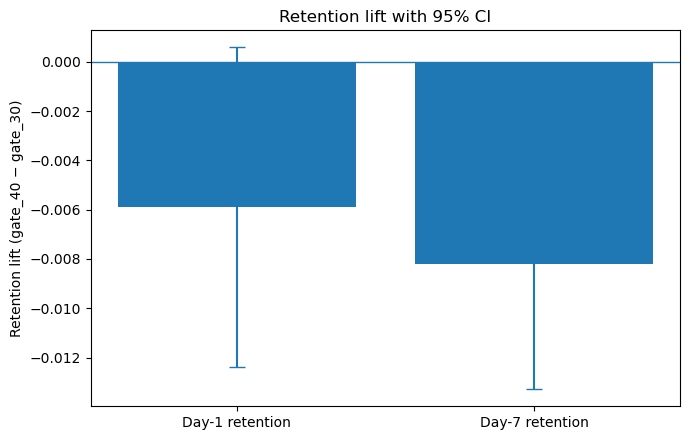

In [36]:
def lift_ci(df, metric, ctrl="gate_30", trt="gate_40", alpha=0.05):
    x_ctrl = df.loc[df["version"] == ctrl, metric].sum()
    n_ctrl = (df["version"] == ctrl).sum()
    x_trt  = df.loc[df["version"] == trt,  metric].sum()
    n_trt  = (df["version"] == trt).sum()

    p_ctrl = x_ctrl / n_ctrl
    p_trt  = x_trt  / n_trt

    lift = p_trt - p_ctrl
    z = stats.norm.ppf(1 - alpha/2)
    se = np.sqrt(p_trt*(1-p_trt)/n_trt + p_ctrl*(1-p_ctrl)/n_ctrl)

    lo = lift - z * se
    hi = lift + z * se
    return lift, lo, hi

labels = ["Day-1 retention", "Day-7 retention"]
metrics = ["retention_1", "retention_7"]

lifts, lows, highs = [], [], []
for m in metrics:
    lift, lo, hi = lift_ci(df, m)
    lifts.append(lift)
    lows.append(lo)
    highs.append(hi)

x = np.arange(len(labels))
y = np.array(lifts)
yerr = np.vstack([y - np.array(lows), np.array(highs) - y])

plt.figure(figsize=(7, 4.5))
plt.bar(x, y)
plt.errorbar(x, y, yerr=yerr, fmt="none", capsize=6)
plt.axhline(0, linewidth=1)
plt.xticks(x, labels)
plt.ylabel("Retention lift (gate_40 − gate_30)")
plt.title("Retention lift with 95% CI")
plt.tight_layout()
plt.show()
